In [20]:
from pathlib import Path

import Anonymize.Anonymization as anonym
import PixelArrays
import pydicom
import nibabel
import numpy as np

from PIL import Image  
from enum import Enum


class ImageType(Enum):
    """
    Enum type for representing image format.
    """
    DCM = 0
    NIFTI = 1
    JPG = 2
    PNG = 3


class ImageObject(object):
    """
    Base class for representing image object and performing methods dedicated for every image type.
    """
    # Path to source folder which stores file
    src_folder = None
    # Filename with extension
    src_filename = None

    # Type of image file specified by enum ImageType
    file_type = None

    # Numpy array of pixel data for image
    pixel_array = None
    # Number of current layer of image
    current_slice_number = 0
    # Image object depending on image type
    image_object = None
    # Possible file extenstions for given file format
    # file_extensions = []
    
    def __init__(self, src_folder, filename):
        
        self.src_folder = src_folder
        self.src_filename = filename
        self.current_slice_number = 0
        self.total_slice_number = 0
    
    def save_anonymized_file(self, filename, destination_folder):
        """ Method saves current image to destination_folder as filename. """
        pass
    
    def get_current_slice(self):
        """ Method returns array containing pixel data for current image. """
        pass

    def get_next_slice(self, value):
        """
        Method load next slice (for dicom or nifti images)
        and returns array containing pixel data for given slice.
        """
        pass

    def get_file_path(self):
        """
        Methods returns path to image file as string.
        """
        return str(Path(self.src_folder) / self.src_filename)

    def get_filename_with_extension(self, filename: str):
        """
        Method check if given filename has correct file extensions.
        If filename has no extension, default extension for this file type will be added.
        If filename has incorrect extension, exception will be thrown.
        :param filename: string representing name of file
        :return: filename or filename with added extenstion
        """
        splitted = filename.split(".")
        if len(splitted) == 1:
            # filename has no extension, so it is added
            print(filename)
            filename = filename + "." + self.file_extensions[0]
        elif splitted[-1] not in self.file_extensions:
            print(self.file_extensions)
            # extension is not correct
            raise TypeError("Wrong file extension: expected {0} but was{1}.".format(self.file_extenstions, splitted[-1]))

        return filename


class DicomImage(ImageObject):
    """
    Class for representing dicom image object.
    """

    # List containing paths to all dicom images in source folder
    slices_path_list = []

    file_extensions = ["dcm", "DCM"]
    
    def __init__(self, folder, filename):
        
        super().__init__(folder, filename)
        self.file_type = ImageType.DCM
        self.image_object = anonym.get_anonymized_dicom(filename, folder)
        self.pixel_array = self.image_object.pixel_array
        self.slices_path_list = list(Path(self.src_folder).iterdir())
        self.total_slice_number = len(self.slices_path_list)
    
    def save_anonymized_file(self, filename, destination_folder):
        
        try:
            filename = self.get_filename_with_extension(filename)
            output_file_path = Path(destination_folder) / filename
            self.image_object.save_as(output_file_path)
            return True
        
        except Exception as ex:
            print(ex)
            return False
    
    def get_current_slice(self):
        
        return self.pixel_array
    
    def get_next_slice(self, value):
        
        if value >= self.total_slice_number:
            self.current_slice_number = self.total_slice_number - 1
        elif value <= 0:
            self.current_slice_number = 0
        else:
            self.current_slice_number = value
            
        self.src_filename = self.slices_path_list[value].name
        
        self.image_object = anonym.get_anonymized_dicom(self.src_filename, self.src_folder)
        self.pixel_array = self.image_object.pixel_array
        return self.pixel_array 
        

class NiftiImage(ImageObject):
    """
    Class for representing nifti1 image object.
    """

    file_extensions = ["nii"]

    def __init__(self, folder, filename):
        
        super().__init__(folder, filename)
        self.file_type = ImageType.NIFTI
        self.image_object = anonym.get_anonymized_nifti(filename, folder)
        self.pixel_array = self.image_object.get_fdata().T
        self.total_slice_number = self.image_object.shape[2]
    
    def save_anonymized_file(self, filename, destination_folder):
        
        try:
            filename = self.get_filename_with_extension(filename)
            output_file_path = Path(destination_folder) / filename
            nibabel.save(self.image_object, output_file_path)
            return True
        
        except Exception as ex:
            print(ex)
            return False
    
    def get_current_slice(self):
        return self.pixel_array[self.current_slice_number]
    
    def get_next_slice(self, value):
        if value >= self.total_slice_number:
            self.current_slice_number = self.total_slice_number - 1
        elif value <= 0:
            self.current_slice_number = 0
        else:
            self.current_slice_number = value
            
        return self.pixel_array[self.current_slice_number]


class JpgImage(ImageObject):
    """
    Class for representing jpg image object.
    """

    file_extensions = ["jpg", "jpeg", "JPG", "JPEG"]
    
    def __init__(self, folder, filename):
        
        super().__init__(folder, filename)
        self.file_type = ImageType.JPG
        self.image_object = anonym.get_anonymized_png_jpg(filename, folder)
        self.pixel_array = np.array(self.image_object)
        self.total_slice_number = 1
    
    def save_anonymized_file(self, filename, destination_folder):
        
        try:
            filename = get_filename_with_extension(filename)
            output_file_path = Path(destination_folder) / filename
            self.image_object.save(output_file_path)
            return True
        
        except Exception as ex:
            print(ex)
            return False
    
    def get_current_slice(self):
        return self.pixel_array
    
    def get_next_slice(self, value):
        return self.pixel_array


class PngImage(ImageObject):
    """
    Class for representing png image object.
    """

    file_extensions = ["png", "PNG"]
    
    def __init__(self, folder, filename):
        
        super().__init__(folder, filename)
        self.file_type = ImageType.PNG
        self.image_object = anonym.get_anonymized_png_jpg(filename, folder)
        self.pixel_array = np.array(self.image_object)
        self.total_slice_number = 1
    
    def save_anonymized_file(self, filename, destination_folder):
        
        try:
            filename = self.get_filename_with_extension(filename)
            output_file_path = Path(destination_folder) / filename
            self.image_object.save(output_file_path)
            return True
        
        except Exception as ex:
            print(ex)
            return False
    
    def get_current_slice(self):
        return self.pixel_array
    
    def get_next_slice(self, value):
        return self.pixel_array




In [6]:
sample_folder = r"D:\Studia\sem7\inzynierka\aplikacja\images_data"
sample_dcm = "Italy_case010000.dcm"
sample_nii = "coronacases_org_001.nii"
sample_jpg = "ct1.jpg"
sample_png = "ct2.png"

In [21]:
img = PngImage(sample_folder, sample_png)
# plt.imshow(img.get_current_slice(), cmap='gray') 
# img.super().save_anonymized_file("new_file", ".")
img.get_filename_with_extension("new_file")
# "new_file".split(".")

new_file


'new_file.png'

In [25]:
dcm = DicomImage(r"D:\Studia\sem7\inzynierka\aplikacja\images_data\pacjent_dcm", "Italy_case010000.dcm")

In [27]:
dcm.pixel_array

array([[7, 7, 7, ..., 7, 7, 7],
       [7, 7, 7, ..., 7, 7, 7],
       [7, 7, 7, ..., 7, 7, 7],
       ...,
       [7, 7, 7, ..., 7, 7, 7],
       [7, 7, 7, ..., 7, 7, 7],
       [7, 7, 7, ..., 7, 7, 7]], dtype=uint16)

In [29]:
res = anonym.get_anonymized_dicom("Italy_case010000.dcm", r"D:\Studia\sem7\inzynierka\aplikacja\images_data\pacjent_dcm1")

File D:\Studia\sem7\inzynierka\aplikacja\images_data\pacjent_dcm1\Italy_case010000.dcm not found


In [32]:
res is None

True

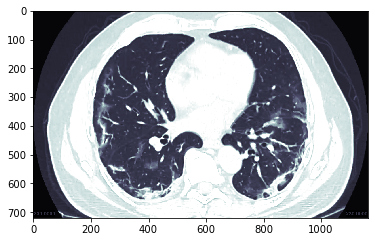

In [82]:
plt.imshow(dcm.get_next_slice(100), cmap=plt.cm.bone) 

In [94]:
dcm.save_anonymized_file("new_file.dcm", ".")

True

In [41]:
type(pa)

numpy.ndarray

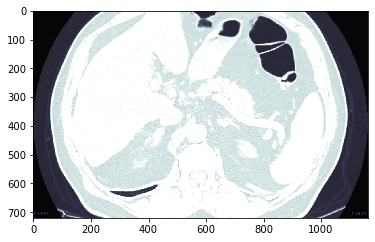

In [8]:
import matplotlib.pyplot as plt
import pydicom
plt.imshow(pa, cmap=plt.cm.bone) 

True

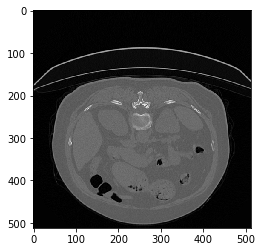

In [99]:
img = NiftiImage(sample_folder, sample_nii)
plt.imshow(img.get_current_slice(), cmap='gray') 
img.image_object.shape[2]
img.save_anonymized_file("new_file.nii", ".")

True

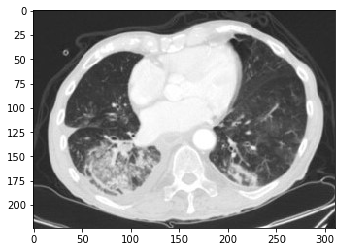

In [101]:
img = JpgImage(sample_folder, sample_jpg)
plt.imshow(img.get_current_slice(), cmap='gray') 
img.save_anonymized_file("new_file.jpg", ".")